# Setup
## Load modules

In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.express as px

plt.rcParams['figure.dpi'] = 300

In [2]:
'''
Combine datasets into one DataFrame
'''
data = geopandas.read_file('data/cbs_pc4_2018_v3.shp')
data.replace(-99997, np.nan, inplace=True)

# add data from Weighdata = data.set_index('PC4')ted_avg_landprice_pc4_1985-2007 to dataset
# p_m2_FE: Weighted average price of invididual transactions per four-digit zipcode area for the period 1985-2007, indexed towards the 2007 price-level
Weighted_avg_landprice_pc4 = pd.read_excel('data/Weighted_avg_landprice_pc4_1985-2007.xls', sheet_name='Data')
data = pd.merge(data, Weighted_avg_landprice_pc4, left_on='PC4', right_on='PC4Code', suffixes=(None,'_VU')).drop('PC4Code', axis=1)

# calculate land area and population density from shapefile and population data
data['km2'] = data.to_crs('epsg:32633').geometry.area / 1_000_000
data['pop_density'] = data.INWONER/data.km2
data = data.set_index('PC4')
data = data.drop([8244])

In [90]:
data_labels = {
    'p_m2_FE': 'Avg. land rent (€/m2)',
    'pop_density': 'Population density (per km2)',
    'OAD': 'Omgevingsadressendichtheid (adressen per km2)',
    'STED': 'Stedelijkheid (code)',
    'AFS_SUPERM': 'Afstand tot dichtstbijzijnde grote supermarkt (km)',
    'AFS_DAGLMD': 'Afstand tot dichtstbijzijnde overige dagelijkse levensmiddelen (km)',
    'AFS_WARENH': 'Afstand tot dichtstbijzijnde warenhuis (km)',
    'AFS_CAFE': 'Afstand tot dichtstbijzijnde café (km)',
    'AFS_CAFTAR': 'Afstand tot dichtstbijzijnde cafetaria (km)',
    'AFS_HOTEL': 'Afstand tot dichtstbijzijnde hotel (km)',
    'AFS_BSO': 'Afstand tot dichtstbijzijnde buitenschoolse opvang (km)',
    'AFS_KDV': 'Afstand tot dichtstbijzijnde kinderdagverblijf (km)',
    'AFS_BRANDW': 'Afstand tot dichtstbijzijnde brandweerkazerne (km)',
    'AFS_OPRIT': 'Afstand tot dichtstbijzijnde oprit hoofdverkeersweg (km)',
    'AFS_TRNOVS': 'Afstand tot dichtstbijzijnde belangrijk overstapstation (km)',
    'AFS_TREINS': 'Afstand tot dichtstbijzijnde treinstation (km)',
    'AFS_ATTRAC': 'Afstand tot dichtstbijzijnde attractiepark (km)',
    'AFS_BIOS': 'Afstand tot dichtstbijzijnde bioscoop (km)',
    'AFS_MUS': 'Afstand tot museum (km)',
    'AFS_PODIUM': 'Afstand tot dichtstbijzijnde locatie podiumkunsten (km)',
    'AFS_BIBLIO': 'Afstand tot dichtstbijzijnde bibliotheek (km)',
    'AF_IJSBAAN': 'Afstand tot dichtstbijzijnde kunstijsbaan (km)',
    'AFS_POP': 'Afstand tot dichtstbijzijnde poppodium (km)',
    'AFS_SAUNA': 'Afstand tot dichtstbijzijnde sauna (km)',
    'AFS_ZONBNK': 'Afstand tot dichtstbijzijnde zonnebank (km)',
    'AFS_ZWEMB': 'Afstand tot dichtstbijzijnde zwembad (km)',
    'AFS_ONDBAS': 'Afstand tot dichtstbijzijnde basisschool (km)',
    'AFS_ONDHV': 'Afstand tot dichtstbijzijnde school HAVO/VWO (km)',
    'AFS_ONDVMB': 'Afstand tot dichtstbijzijnde school VMBO (km)',
    'AFS_ONDVRT': 'Afstand tot dichtstbijzijnde voortgezet onderwijs (km)',
    'AFS_HAPRAK': 'Afstand tot dichtstbijzijnde huisartsenpraktijk (km)',
    'AFS_ZIEK_E': 'Afstand tot dichtstbijzijnde ziekenhuis excl. Buitenpolikliniek (km)',
    'AFS_ZIEK_I': 'Afstand tot dichtstbijzijnde ziekenhuis incl. buitenpolikliniek (km)',
    'AFS_APOTH': 'Afstand tot dichtstbijzijnde apotheek (km)',
    'AFS_HAPOST': 'Afstand tot dichtstbijzijnde huisartsenpost (km)',
    'AV5_SUPERM': 'Aantal grote supermarkten binnen 5 kilometer (aantal)',
    'AV5_HAPRAK': 'Aantal huisartsenpraktijken binnen 5 kilometer (aantal)',
    'AV5_ONDBAS': 'Aantal basisscholen binnen 5 kilometer (aantal)',
    'AV5_ONDVRT': 'Aantal scholen voortgezet onderwijs binnen 5 kilometer (aantal)'

}


In [91]:
'''
Plot Weighted_avg_landprice_pc4_1985-2007 in Amsterdam on a map.
'''
# define different map levels of the Netherlands
mra_gemeentes = ['Aalsmeer', 'Almere', 'Amstelveen', 'Amsterdam', 'Beverwijk', 'Blaricum', 'Bloemendaal', 'Diemen',
                 'Edam-Volendam', 'Gooise Meren', 'Haarlem', 'Haarlemmermeer', 'Heemskerk', 'Heemstede', 'Hilversum',
                 'Huizen', 'Landsmeer', 'Laren', 'Lelystad', 'Oostzaan', 'Ouder-Amstel', 'Purmerend', 'Uitgeest',
                 'Uithoorn', 'Velsen', 'Waterland', 'Wijdemeren', 'Wormerland', 'Zaanstad', 'Zandvoort']
groot_amsterdam_gemeentes = ['Amsterdam', 'Haarlemmermeer', 'Amstelveen', 'Aalsmeer', 'Uithoorn', 'Ouder-Amstel',
                             'Diemen', 'Zaanstad', 'Purmerend', 'Waterland', 'Oostzaan', 'Landsmeer', 'Wormerland',
                             'Edam-Volendam', 'Uitgeest']

mra = data[data['Gemeente'].isin(mra_gemeentes)]
groot_amsterdam = data[data['Gemeente'].isin(groot_amsterdam_gemeentes)]
amsterdam = data[data['Gemeente'] == 'Amsterdam']

In [92]:
def plot(data, column):
    '''Plot a data column on a 4-digit zipcode level to a map of a certain region (selected using data)'''
    data.plot(column=column, legend=True, 
                    norm=matplotlib.colors.LogNorm(vmin=data[column].min(), vmax=data[column].max())
                    )
    ax = plt.gca()
    ax.set_title(data_labels.get(column, column) + ' on 4-digit zipcode level')
    ax.set_axis_off()
    plt.show()

In [93]:
'''
Plot Linear Regression of data to see if a trend between a factor and the land price per m2 can be found.
Return Linear Regression function so it can be used later.
'''


def plot_relation(data_temp, column, title=''):
    '''Fit the dataframe to a linear regression model using the p_m2_FE and given column'''
    data_temp = data_temp.dropna(subset=column)

    fig = px.scatter(data_temp, x=column, y='p_m2_FE', trendline="ols", log_x=True, log_y=True,
                     trendline_options=dict(log_x=True, log_y=True), trendline_color_override='red',
                     labels=data_labels, title=title)
    fig.show()


def reg(data, column, sample_weight=None):
    '''Fit the dataframe to a linear regression model using the p_m2_FE and given column and return the model'''
    data_temp = data.dropna(subset=column)

    # linear regression
    X = np.array(np.log(data_temp[column])).reshape(-1, 1)
    y = np.log(data_temp['p_m2_FE'])
    reg = LinearRegression().fit(X, y, sample_weight=sample_weight)

    return reg

In [94]:
'''
Fit linear regression to different available levels of data.
'''

def linreg(m):
    X = mra.dropna(subset=m)[m]
    y = mra.dropna(subset=m)['p_m2_FE']
    reg = LinearRegression().fit(X, y)

    print(reg.score(X,y))
    
    
# there seems to be a linear correlation between population density

linreg(['AFS_SUPERM', 'AFS_DAGLMD', 'AFS_WARENH', 'AFS_CAFE', 'AFS_CAFTAR', 'AFS_HOTEL',
                'AFS_BSO', 'AFS_KDV', 'AFS_BRANDW', 'AFS_OPRIT', 'AFS_TRNOVS', 'AFS_TREINS', 'AFS_ATTRAC', 'AFS_BIOS',
                'AFS_MUS', 'AFS_PODIUM', 'AFS_BIBLIO', 'AF_IJSBAAN', 'AFS_POP', 'AFS_SAUNA', 'AFS_ZONBNK', 'AFS_ZWEMB',
                'AFS_ONDBAS', 'AFS_ONDHV', 'AFS_ONDVMB', 'AFS_ONDVRT', 'AFS_HAPRAK', 'AFS_ZIEK_E', 'AFS_ZIEK_I',
                'AFS_APOTH', 'AFS_HAPOST' ])
# there seems to be some linear correlation between distances to different services

linreg(['pop_density', 'AFS_SUPERM', 'AFS_DAGLMD', 'AFS_WARENH', 'AFS_CAFE', 'AFS_CAFTAR', 'AFS_HOTEL',
                'AFS_BSO', 'AFS_KDV', 'AFS_BRANDW', 'AFS_OPRIT', 'AFS_TRNOVS', 'AFS_TREINS', 'AFS_ATTRAC', 'AFS_BIOS',
                'AFS_MUS', 'AFS_PODIUM', 'AFS_BIBLIO', 'AF_IJSBAAN', 'AFS_POP', 'AFS_SAUNA', 'AFS_ZONBNK', 'AFS_ZWEMB',
                'AFS_ONDBAS', 'AFS_ONDHV', 'AFS_ONDVMB', 'AFS_ONDVRT', 'AFS_HAPRAK', 'AFS_ZIEK_E', 'AFS_ZIEK_I',
                'AFS_APOTH', 'AFS_HAPOST' ])
# combining these gives even more correlation

0.4328309794494327
0.48853056226410774


In [95]:
m = ['pop_density', 'AFS_SUPERM', 'AFS_DAGLMD', 'AFS_WARENH', 'AFS_CAFE', 'AFS_CAFTAR', 'AFS_HOTEL',
                'AFS_BSO', 'AFS_KDV', 'AFS_BRANDW', 'AFS_OPRIT', 'AFS_TRNOVS', 'AFS_TREINS', 'AFS_ATTRAC', 'AFS_BIOS',
                'AFS_MUS', 'AFS_PODIUM', 'AFS_BIBLIO', 'AF_IJSBAAN', 'AFS_POP', 'AFS_SAUNA', 'AFS_ZONBNK', 'AFS_ZWEMB',
                'AFS_ONDBAS', 'AFS_ONDHV', 'AFS_ONDVMB', 'AFS_ONDVRT', 'AFS_HAPRAK', 'AFS_ZIEK_E', 'AFS_ZIEK_I',
                'AFS_APOTH', 'AFS_HAPOST' ]
m = ['AFS_SUPERM', 'AFS_OPRIT', 'AFS_TREINS', 'AFS_HAPRAK', 'AFS_ONDBAS', 'AFS_ONDVRT', 'AFS_PODIUM', 'OAD',]
m = ['AV5_SUPERM', 'AFS_OPRIT', 'AFS_TREINS', 'AV5_HAPRAK', 'AV5_ONDBAS', 'AV5_ONDVRT', 'AFS_PODIUM', 'OAD',]

In [96]:
from sklearn.linear_model import LinearRegression
# regression coefficients

def cdf(dataset):
    X = dataset.dropna(subset=m)[m]
    y = dataset.dropna(subset=m)['p_m2_FE']
    reg = LinearRegression().fit(X, y)
    
    print(reg.score(X,y))

    return pd.DataFrame(reg.coef_, X.columns, columns=['Coefficients'])

print(cdf(mra))

0.6723291293317466
            Coefficients
AV5_SUPERM      1.771670
AFS_OPRIT      47.425687
AFS_TREINS      8.260460
AV5_HAPRAK      6.187601
AV5_ONDBAS      0.755232
AV5_ONDVRT      8.080929
AFS_PODIUM     15.214228
OAD             0.028506


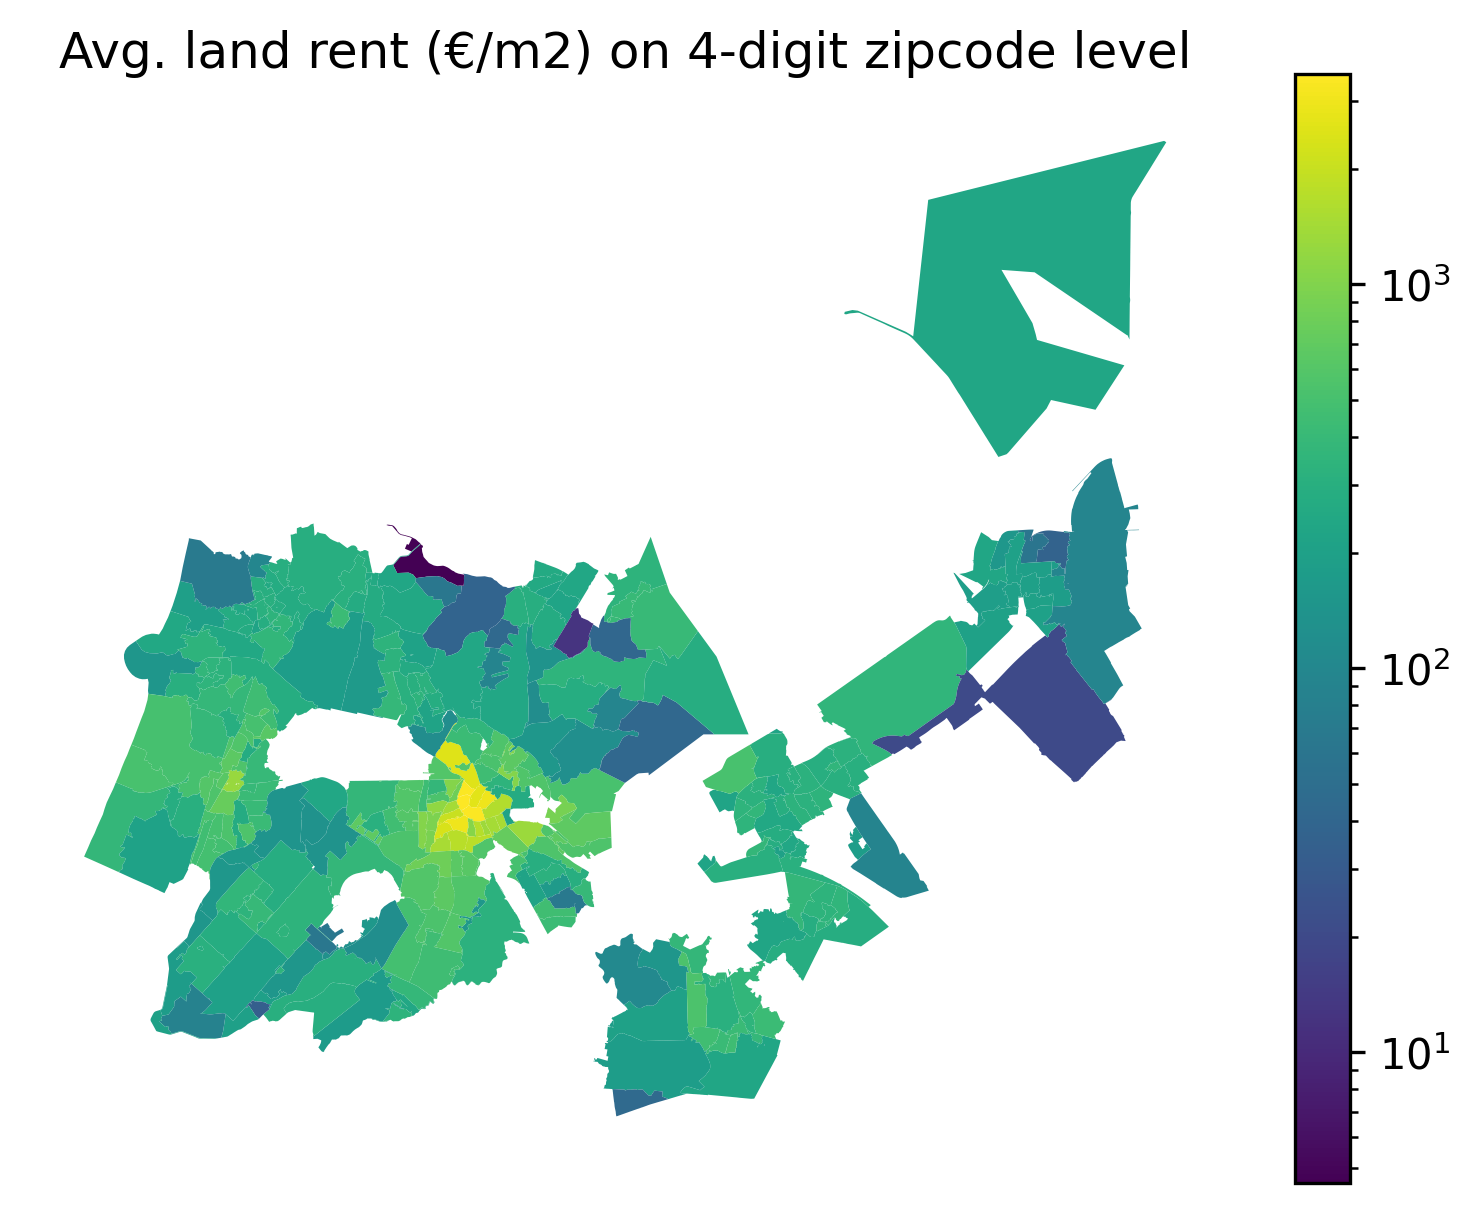

In [97]:
plot(mra, 'p_m2_FE')


In [98]:
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

def decompose(location, m):
    m=list(m)
    ''''''
    X = data.dropna(subset=m)[m]
    y = data.dropna(subset=m)['p_m2_FE']
    reg = LinearRegression().fit(X, y)
    
    X = data[m]
    
    x_plot = []
    y_plot = []
        
    for factor in m:
        X_compare = X.copy()
        X_compare.loc[location, factor] = data[factor].mean()

        predict = reg.predict(X.loc[[location]])
        predict_mean = reg.predict(X_compare.loc[[location]])
        
        x_plot.append(predict[0] - predict_mean[0])
        y_plot.append(data_labels.get(factor, factor))
            
    x_delta = data.loc[location, 'p_m2_FE']-data['p_m2_FE'].mean()
    
    residue = x_delta - sum(x_plot)
    
    x_plot.append(residue)
    y_plot.append('Residue')
    
    x_plot.append(x_delta)
    y_plot.append('Difference in land values')
    
    fig = go.Figure(go.Bar(x=x_plot, y=y_plot, orientation='h'))
    fig.update_yaxes(tickmode='linear')
    fig['data'][0].width = 1
    title = f'Effect of factors on land values in postal code {str(location)} compared to average'
    fig.update_layout(title_text=title)
    fig.show()




In [100]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



m1 = ['AFS_BSO', 'AFS_HAPRAK', 'AFS_TRNOVS', 'AFS_ONDHV', 'AFS_WARENH', 'AFS_APOTH', 'AFS_TREINS', 'AFS_BRANDW', 'AFS_CAFE', 'AFS_POP', 'AFS_KDV', 'AV5_HAPRAK', 'AFS_HOTEL', 'AFS_ONDBAS', 'AFS_ZONBNK', 'AFS_CAFTAR', 'AFS_ONDVRT', 'AFS_SAUNA', 'AFS_PODIUM', 'AV5_ONDBAS', 'AFS_OPRIT', 'OAD', 'AV5_SUPERM', 'AF_IJSBAAN', 'AFS_MUS', 'AFS_ONDVMB', 'AFS_ZWEMB', 'AFS_SUPERM', 'AFS_ATTRAC', 'AFS_BIOS', 'AFS_HAPOST', 'AV5_ONDVRT', 'AFS_DAGLMD', 'AFS_BIBLIO', 'AFS_ZIEK_E', 'AFS_ZIEK_I']
m2 = ['AFS_SUPERM', 'AFS_OPRIT', 'AFS_TREINS', 'AFS_HAPRAK', 'AFS_ONDBAS', 'AFS_ONDVRT', 'AFS_PODIUM', 'OAD',]
m3 = ['AV5_SUPERM', 'AFS_OPRIT', 'AFS_TREINS', 'AV5_HAPRAK', 'AV5_ONDBAS', 'AV5_ONDVRT', 'AFS_PODIUM', 'OAD',]
pc = widgets.BoundedIntText(
    value=1111,
    min=1000,
    max=9999,
    step=1,
    description='Postcode:',
    disabled=False
)
mask = widgets.TagsInput(
    allowed_tags=m1,
    value=['AV5_SUPERM', 'AFS_OPRIT', 'AFS_TREINS', 'AV5_HAPRAK', 'AV5_ONDBAS', 'AV5_ONDVRT', 'AFS_PODIUM', 'OAD'],
    description='Factors:',
    disabled=False
)

interact_manual(decompose, location=pc, m=mask)

interactive(children=(BoundedIntText(value=1111, description='Postcode:', max=9999, min=1000), TagsInput(value…

<function __main__.decompose(location, m)>

In [33]:
decompose(2135)
decompose(1098)
decompose(1111)

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

def influence(dataset, location, factor):
    ''''''
    X = dataset.dropna(subset=m)[m]
    y = dataset.dropna(subset=m)['p_m2_FE']
    reg = LinearRegression().fit(X, y)
    
    X = dataset[m]
    X_min = X.copy()
    X_max = X.copy()
    
    low_value = dataset[factor].quantile(0.1)
    high_value = dataset[factor].quantile(0.9)
    
    X_min.loc[location, factor] = low_value
    X_max.loc[location, factor] = high_value
    

    # predict value using dataset from the specified location and an imaginary similar location where factor is changed
    predict = reg.predict(X.loc[[location]])
    predict_min = reg.predict(X_min.loc[[location]])
    predict_max = reg.predict(X_max.loc[[location]])
    
    true = dataset.loc[[location], 'p_m2_FE'].unique()
    true_factor = dataset.loc[[location], factor].sum()
    predict_score = mean_absolute_percentage_error(true, predict)
    predict_min_score = mean_absolute_percentage_error(true, predict_min)
    predict_max_score = mean_absolute_percentage_error(true, predict_max)
    
    a = (predict_min[0] - predict_max[0])

    print(f'''Impact of {data_labels.get(factor, factor)} on land values in postcode {location} in {dataset.loc[[
location], 'Gemeente'].unique()[0]}: €{round(a, 2)}/m2 (or {round(a/predict[0]*100, 2)}% of the land value) ''')


In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

def influence_two(dataset, factor):
    X = dataset.dropna(subset=m)[m]
    y = dataset.dropna(subset=m)['p_m2_FE']
    reg = LinearRegression().fit(X, y)
    
    X_min = X.copy()
    X_max = X.copy()
    
    low_value = dataset[factor].quantile(0.3)
    high_value = dataset[factor].quantile(0.7)
    
    X_min[factor] = low_value
    X_max[factor] = high_value
    

    # predict value using dataset from the specified location and an imaginary similar location where factor is changed
    predict = reg.predict(X)
    predict_min = reg.predict(X_min)
    predict_max = reg.predict(X_max)
    
    influence = ((predict_min - predict_max) / (low_value - high_value)).mean()

#     print(f'''Impact of {data_labels.get(factor, factor)} on land values in datasetset: €{round(influence, 2)}/m2 per unit''')
    return round(influence, 2)

In [69]:
influence(mra, 1111, 'AFS_WARENH')
plot_relation(mra, 'AFS_PODIUM')


factors = {}

for factor in m:
    factors[data_labels.get(factor, factor)] = influence_two(mra, factor)

# factors gives the same result as the coefficients and is therefore not needed

Impact of Afstand tot dichtstbijzijnde warenhuis (km) on land values in postcode 1111 in Diemen: €99.12/m2 (or 21.29% of the land value) 



Postcode 1111 in Diemen.
True value: €544.2/m2
    
Predicted values for different values of Afstand tot dichtstbijzijnde warenhuis (km)
True distance of location in datasetset (0.9): €465.54/m2 (14.5%)
Low distance in datasetset (0.8): €467.99/m2 (14.0%)
High distance in datasetset (4.8): €368.87/m2 (32.2%)
    
Impact of Afstand tot dichtstbijzijnde warenhuis (km) on land values in postcode 1111 in Diemen: €99.12/m2 (or 21.29% of the land value) 
    


{'Population density (per km2)': 0.04,
 'Afstand tot dichtstbijzijnde grote supermarkt (km)': -26.92,
 'Afstand tot dichtstbijzijnde overige dagelijkse levensmiddelen (km)': 7.47,
 'Afstand tot dichtstbijzijnde warenhuis (km)': -24.6,
 'Afstand tot dichtstbijzijnde café (km)': 8.25,
 'Afstand tot dichtstbijzijnde cafetaria (km)': -10.64,
 'Afstand tot dichtstbijzijnde hotel (km)': -12.74,
 'Afstand tot dichtstbijzijnde buitenschoolse opvang (km)': -49.19,
 'Afstand tot dichtstbijzijnde kinderdagverblijf (km)': 80.94,
 'Afstand tot dichtstbijzijnde brandweerkazerne (km)': -10.37,
 'Afstand tot dichtstbijzijnde oprit hoofdverkeersweg (km)': 104.29,
 'Afstand tot dichtstbijzijnde belangrijk overstapstation (km)': -18.29,
 'Afstand tot dichtstbijzijnde treinstation (km)': 4.05,
 'Afstand tot dichtstbijzijnde attractiepark (km)': 7.77,
 'Afstand tot dichtstbijzijnde bioscoop (km)': -7.26,
 'Afstand tot museum (km)': -27.9,
 'Afstand tot dichtstbijzijnde locatie podiumkunsten (km)': 1.11,
 '

In [36]:
'''
Plotting the log-log plot of the average land rent versus population density shows a clear correlation (Fig. 1).
Within cities this relation is not as clear (Fig. 2). The trend in Fig. 1 can be explained by the fact that cities are
usually more densely populated and usually have higher land rents than towns or villages, explaining an overall trend
between population density and average land rent. But when looking at the same relation within cities such a relation seems
to be less apparent.
'''
plot_relation(data, 'pop_density', 'Figure 1: Land rent is related to population density')
plot_relation(data[data['STED'] == 1], 'pop_density', 'Figure 2: Within cities this relation is weaker')



NameError: name 'plot_relation' is not defined

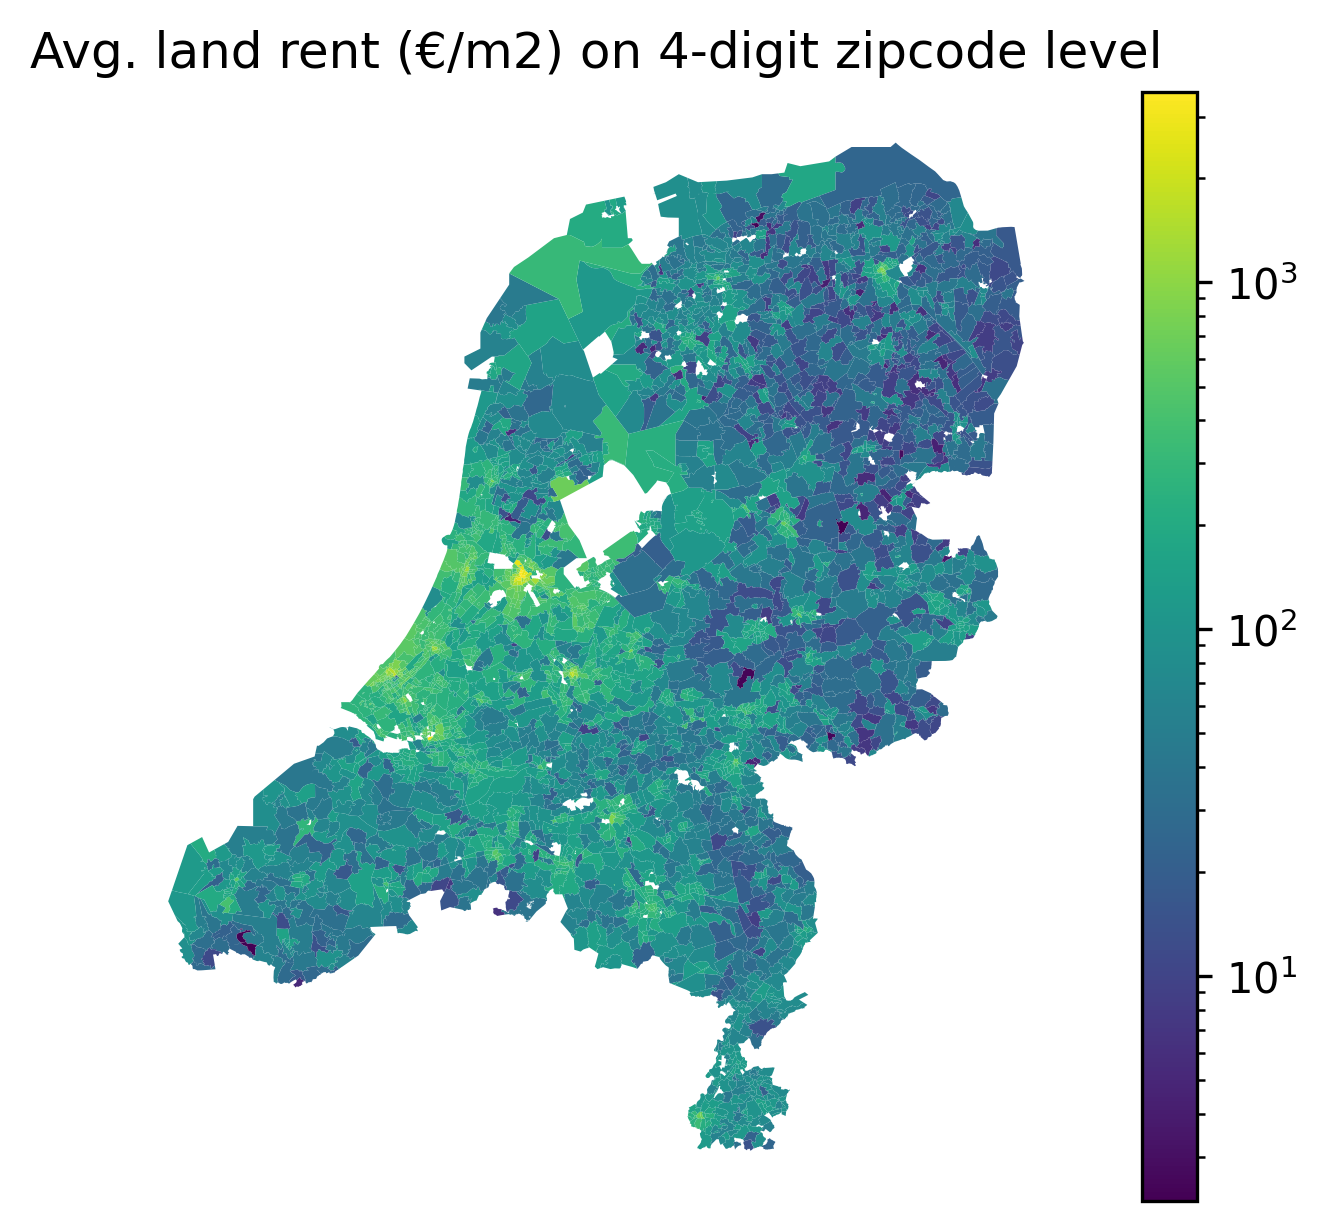

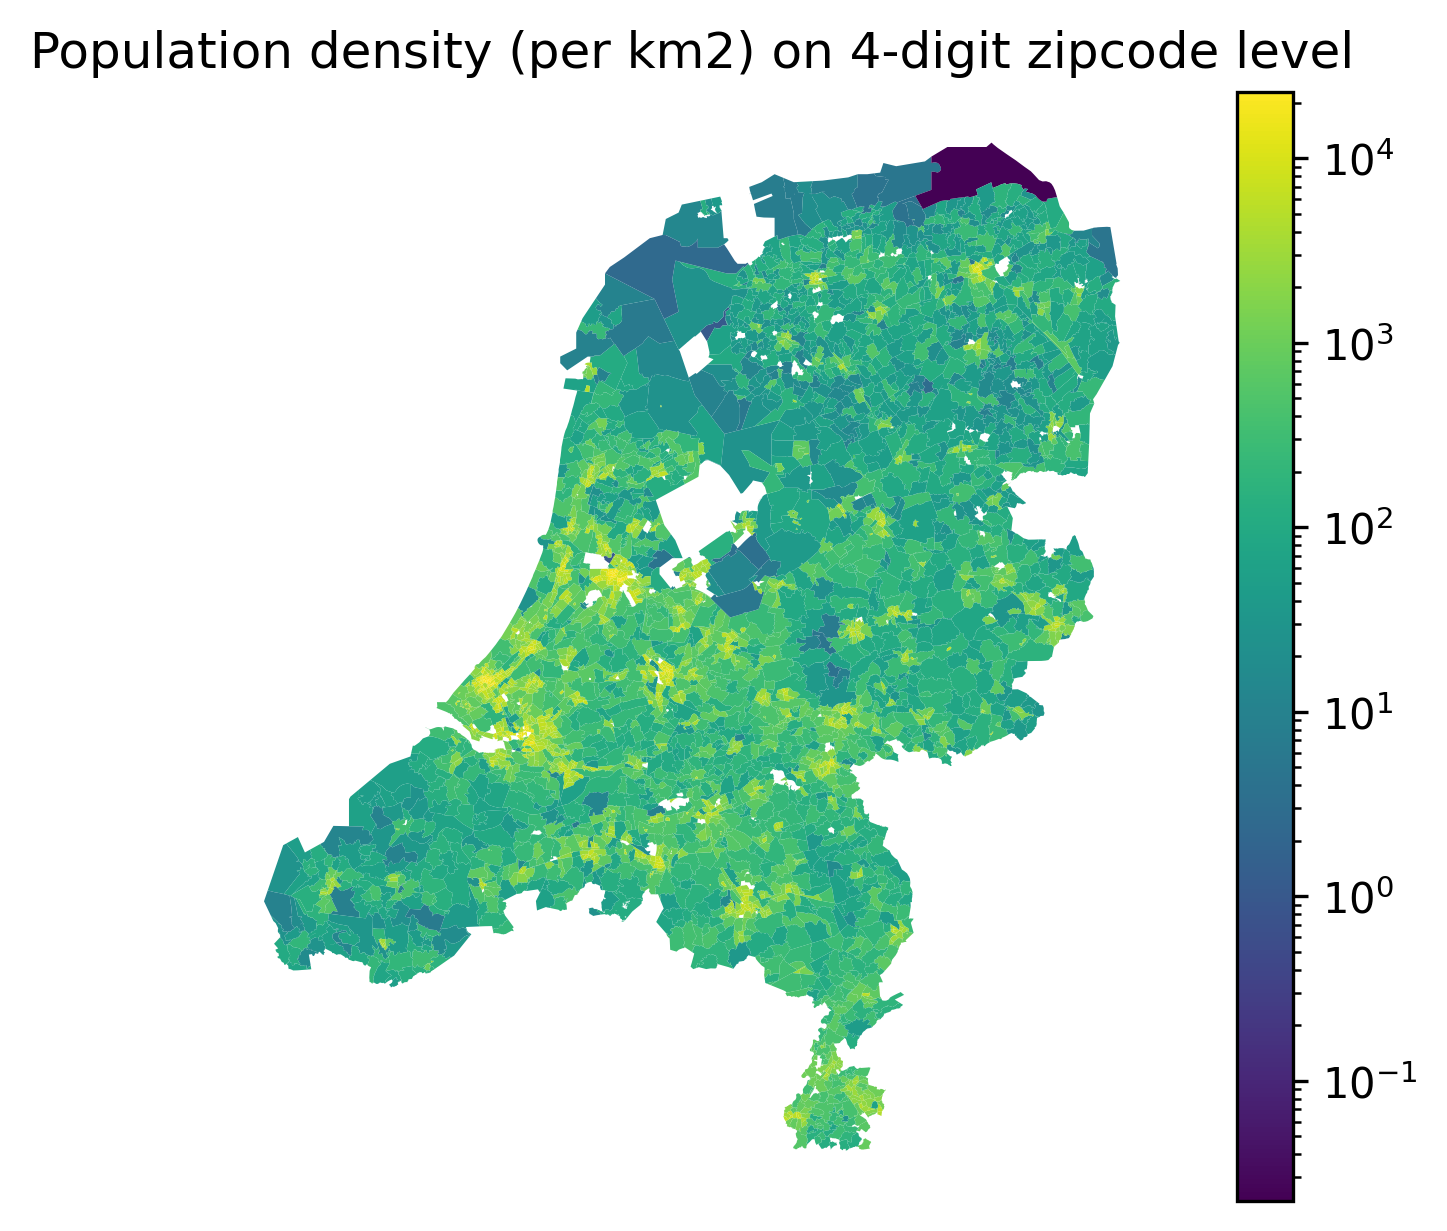

In [37]:
'''
We can map both the avg. land rent and population density in the Netherlands which gives very similar looking maps.
'''
plot(data, 'p_m2_FE')
plot(data, 'pop_density')

In [38]:
'''
Within the Metropoolregio Amsterdam (MRA) a similar, but slightly weaker, relation can be found between average land rent
and population density, as shown below.
'''
pop_density_mra = plot_relation(mra, 'pop_density', 'Land rent is related to population density')
plot(mra, 'p_m2_FE')
plot(mra, 'pop_density')

NameError: name 'plot_relation' is not defined

# Distance to services
## Secondary education

In [ ]:
data_labels['AFS_ONDVRT'] = 'Afstand tot dichtstbijzijnde voortgezet onderwijs (km)'
data_labels['AFS_ONDVMB'] = 'Afstand tot dichtstbijzijnde school VMBO (km)'
data_labels['AFS_ONDHV'] = 'Afstand tot dichtstbijzijnde school HAVO/VWO (km)'
plot_relation(mra, 'AFS_ONDVRT')
plot_relation(mra, 'AFS_ONDVMB')
plot_relation(mra, 'AFS_ONDHV')

## Culture vs security

In [ ]:
data_labels['AFS_BIBLIO'] = 'Afstand tot dichtstbijzijnde bibliotheek (km)'
data_labels['AFS_PODIUM'] = 'Afstand tot dichtstbijzijnde locatie podiumkunsten (km)'
data_labels['AFS_BRANDW'] = 'Afstand tot dichtstbijzijnde brandweerkazerne (km)'



plot_relation(mra, 'AFS_PODIUM')
plot_relation(mra, 'AFS_BIBLIO')
plot_relation(mra, 'AFS_BRANDW')


## GP's and Hospitals

In [ ]:
data_labels['AFS_HAPRAK'] = 'Afstand tot dichtstbijzijnde huisartsenpraktijk (km)'
data_labels['AFS_ZIEK_E'] = 'Afstand tot dichtstbijzijnde ziekenhuis excl. Buitenpolikliniek (km)'
plot_relation(mra, 'AFS_HAPRAK')
plot_relation(mra, 'AFS_ZIEK_E')

In [ ]:
data_labels['G_ELEK_WON'] = 'Gemiddeld elektriciteitsverbruik (kWh)'
plot_relation(data, 'AFS_MUS')
plot(data, 'AFS_MUS')
